In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle competitions/"

In [ ]:
# create folder
#!mkdir '/content/drive/MyDrive/kaggle competitions/img_classification_1'
%cd '/content/drive/MyDrive/kaggle competitions/img_classification_1'

/content/drive/MyDrive/kaggle competitions/img_classification_1


In [ ]:
#!kaggle datasets download -d ganeshmundra/classification-of-images

In [ ]:
import torch
import torchvision
import torchvision.transforms as tt
from torchvision.io import read_image, ImageReadMode

In [ ]:
data_dir = '/content/drive/MyDrive/kaggle competitions/img_classification_1/dataset'
os.listdir(data_dir)

['test.csv', 'train.csv', 'Test Images', 'Train Images']

In [ ]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/kaggle competitions/img_classification_1/dataset/train.csv')
test=pd.read_csv('/content/drive/MyDrive/kaggle competitions/img_classification_1/dataset/test.csv')
train.head()

,Image,Class
0,image7042.jpg,Food
1,image3327.jpg,misc
2,image10335.jpg,Attire
3,image8019.jpg,Food
4,image2128.jpg,Attire


In [ ]:
train.shape

(5983, 2)

In [ ]:
train.Class.unique()

array(['Food', 'misc', 'Attire', 'Decorationandsignage'], dtype=object)

In [ ]:
Class_map={'Food':0,'Attire':1,'Decorationandsignage':2,'misc':3}
inverse_map={0:'Food',1:'Attire',2:'Decorationandsignage',3:'misc'}
train['Class']=train['Class'].map(Class_map)

In [ ]:
resizer = tt.Resize([128, 128])

In [ ]:
train_img=[]
train_label=[]
j=0

path='/content/drive/MyDrive/kaggle competitions/img_classification_1/dataset/Train Images'
for i in tqdm(train['Image']):
    final_path=os.path.join(path,i)
    img=read_image(final_path)
    img = resizer(img)
    train_img.append(img)
    train_label.append(train['Class'][j])
    j=j+1

  2%|▏         | 113/5983 [01:15<1:05:07,  1.50it/s]


KeyboardInterrupt: ignored

In [ ]:
for i in range(len(train_img)):
  if train_img[i].size(0) == 1:
    train_img[i] = train_img[i].repeat(3,1,1)
  elif train_img[i].size(0) > 3:
    train_img[i] = train_img[i][0:3]

In [ ]:
train_inputs = torch.stack(train_img, dim=0)

In [ ]:
train_inputs[0]

tensor([[[57., 58., 59.,  ..., 58., 57., 56.],
         [59., 60., 61.,  ..., 59., 58., 57.],
         [62., 63., 64.,  ..., 61., 60., 59.],
         ...,
         [26., 26., 26.,  ..., 22., 22., 22.],
         [26., 26., 26.,  ..., 22., 21., 21.],
         [25., 25., 25.,  ..., 21., 20., 20.]],

        [[45., 46., 47.,  ..., 47., 46., 45.],
         [47., 48., 49.,  ..., 48., 47., 46.],
         [50., 51., 52.,  ..., 50., 49., 48.],
         ...,
         [22., 22., 22.,  ..., 18., 18., 18.],
         [22., 22., 22.,  ..., 18., 17., 17.],
         [21., 21., 21.,  ..., 17., 16., 16.]],

        [[45., 46., 47.,  ..., 45., 44., 43.],
         [47., 48., 49.,  ..., 46., 45., 44.],
         [50., 51., 52.,  ..., 48., 47., 46.],
         ...,
         [24., 24., 24.,  ..., 19., 19., 18.],
         [23., 23., 23.,  ..., 19., 18., 18.],
         [22., 22., 22.,  ..., 18., 17., 17.]]])

In [ ]:
torch.can_cast(torch.uint8, torch.float32)

True

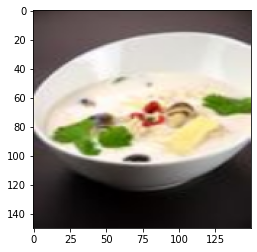

In [ ]:
plt.imshow((train_inputs[0].permute(1,2,0)).type(torch.uint8))

In [ ]:
train_inputs = train_inputs.to(torch.float32)

In [ ]:
train_label = np.array(train_label)

In [ ]:
train_outputs = torch.from_numpy(train_label)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, random_split

In [ ]:
train_dataset = TensorDataset(train_inputs, train_outputs)

In [ ]:
len(train_dataset)

5983

In [ ]:
train_size = int(len(train_dataset) * 0.8)
val_size = len(train_dataset) - train_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(4786, 1197)

In [ ]:
batch_size = 100
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
from torchvision.utils import make_grid

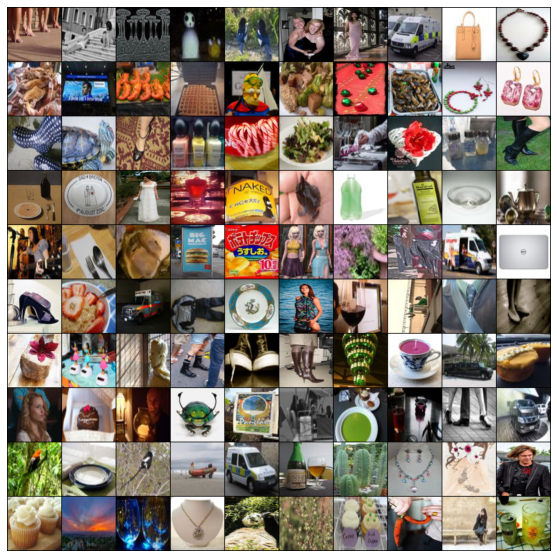

In [ ]:
for images, _ in train_dl:
  plt.figure(figsize=(10,10))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=10).permute(1,2,0).type(torch.uint8))
  break

In [ ]:
def accuracy(out, targets):
  _, preds = torch.max(out, dim=1)
  return torch.tensor(torch.sum(preds == targets).item() / len(preds))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class ModelBase(nn.Module):
  def training_step(self, batch):
    xb, targets = batch
    out = self(xb)
    loss = F.cross_entropy(out, targets)
    return loss

  def validation_step(self, batch):
    xb, targets = batch
    out = self(xb)
    val_loss = F.cross_entropy(out, targets)
    val_acc = accuracy(out, targets)
    return {'val_loss': val_loss, 'val_acc': val_acc}

  def validation_epoch_end(self, res):
    losses = [x['val_loss'] for x in res]
    epoch_loss = torch.stack(losses).mean()
    accs = [x['val_acc'] for x in res]
    epoch_acc = torch.stack(accs).mean()
    return {'epoch_loss': epoch_loss.item(), 'epoch_acc': epoch_acc.item()}

  def epoch_end(self, epoch, res):
    print(f'Epoch [{epoch}], Train loss [{round(res["train_loss"], 4)}], Val loss [{round(res["epoch_loss"], 4)}], Val accuracy [{round(res["epoch_acc"], 4)}]')

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
try_model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2))

In [ ]:
for images, labels in train_dl:
  print(images.shape)
  out = try_model(images)
  print(out.shape)
  break

torch.Size([100, 3, 150, 150])
torch.Size([100, 256, 18, 18])


In [ ]:
class Model1(ModelBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Flatten(),
        nn.Linear(256*18*18, 2056),
        nn.ReLU(),
        nn.Linear(2056, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 8),
        nn.ReLU(),
        nn.Linear(8, 4)
    )

  def forward(self, xb):
    return self.network(xb)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
model1 = Model1()

In [ ]:
model1 = to_device(model1, device)

In [ ]:
@torch.no_grad()
def evaluate(model, dl):
  model.eval()
  res = [model.validation_step(b) for b in dl]
  return model.validation_epoch_end(res)

def fit(n_epochs, model, train_dl, val_dl, lr, opt_f=torch.optim.SGD):
  history = []
  opt = opt_f(model.parameters(), lr)
  for epoch in range(n_epochs):
    model.train()
    train_losses = []
    for batch in train_dl:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      opt.step()
      opt.zero_grad()

    res = evaluate(model, val_dl)
    res['train_loss'] = torch.stack(train_losses).mean().item()
    history.append(res)
    model.epoch_end(epoch, res)
  return history

In [ ]:
history1 = [evaluate(model1, val_dl)]
history1

[{'epoch_acc': 0.38675975799560547, 'epoch_loss': 1.3817565441131592}]

In [ ]:
n_epochs = 10
lr = 0.005
opt_f = torch.optim.Adam

In [ ]:
history1 += fit(n_epochs, model1, train_dl, val_dl, lr, opt_f)

Epoch [0], Train loss [14.1938], Val loss [1.3402], Val accuracy [0.3868]
Epoch [1], Train loss [1.3376], Val loss [1.3143], Val accuracy [0.3868]
Epoch [2], Train loss [1.3226], Val loss [1.3043], Val accuracy [0.3868]
Epoch [3], Train loss [1.3177], Val loss [1.3023], Val accuracy [0.3868]
Epoch [4], Train loss [1.3164], Val loss [1.302], Val accuracy [0.3868]
Epoch [5], Train loss [1.3163], Val loss [1.3025], Val accuracy [0.3868]
Epoch [6], Train loss [1.3163], Val loss [1.3028], Val accuracy [0.3868]
Epoch [7], Train loss [1.3162], Val loss [1.3021], Val accuracy [0.3868]
Epoch [8], Train loss [1.3161], Val loss [1.3022], Val accuracy [0.3868]
Epoch [9], Train loss [1.316], Val loss [1.3019], Val accuracy [0.3868]


In [ ]:
n_epochs = 10
lr = 0.001
opt_f = torch.optim.Adam
history1 += fit(n_epochs, model1, train_dl, val_dl, lr, opt_f)

Epoch [0], Train loss [1.3159], Val loss [1.302], Val accuracy [0.3868]
Epoch [1], Train loss [1.3161], Val loss [1.3021], Val accuracy [0.3868]
Epoch [2], Train loss [1.316], Val loss [1.302], Val accuracy [0.3868]
Epoch [3], Train loss [1.3161], Val loss [1.3019], Val accuracy [0.3868]
Epoch [4], Train loss [1.316], Val loss [1.302], Val accuracy [0.3868]
Epoch [5], Train loss [1.3161], Val loss [1.302], Val accuracy [0.3868]
Epoch [6], Train loss [1.316], Val loss [1.3019], Val accuracy [0.3868]
Epoch [7], Train loss [1.3161], Val loss [1.3022], Val accuracy [0.3868]
Epoch [8], Train loss [1.316], Val loss [1.3023], Val accuracy [0.3868]
Epoch [9], Train loss [1.3159], Val loss [1.3017], Val accuracy [0.3868]


In [ ]:
n_epochs = 10
lr = 1e-7
opt_f = torch.optim.Adam
history1 += fit(n_epochs, model1, train_dl, val_dl, lr, opt_f)

Epoch [0], Train loss [1.316], Val loss [1.3017], Val accuracy [0.3868]
Epoch [1], Train loss [1.316], Val loss [1.3017], Val accuracy [0.3868]
Epoch [2], Train loss [1.3158], Val loss [1.3017], Val accuracy [0.3868]
Epoch [3], Train loss [1.316], Val loss [1.3017], Val accuracy [0.3868]
Epoch [4], Train loss [1.3159], Val loss [1.3017], Val accuracy [0.3868]
Epoch [5], Train loss [1.3158], Val loss [1.3017], Val accuracy [0.3868]
Epoch [6], Train loss [1.3159], Val loss [1.3017], Val accuracy [0.3868]
Epoch [7], Train loss [1.3159], Val loss [1.3017], Val accuracy [0.3868]
Epoch [8], Train loss [1.316], Val loss [1.3017], Val accuracy [0.3868]
Epoch [9], Train loss [1.3158], Val loss [1.3017], Val accuracy [0.3868]


In [ ]:
def predict_image(img, model):
  img = torch.tensor([img], dtype=torch.float32)
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return inverse_map[preds[0].item()]

In [ ]:
predict_image(train_ds[0], model1)

ValueError: ignored

In [ ]:
def plot_losses(history):
  history = history[1:]
  losses = [x['epoch_loss'] for x in history]
  train_losses = [x['train_loss'] for x in history]
  plt.figure(figsize=(20,8))
  plt.plot(train_losses, label='Train loss')
  plt.plot(losses, '-x', label='Validation loss')
  plt.xlabel('Cross entropy score')
  plt.ylabel('Epoch')
  plt.title('Losses X Epochs')
  plt.legend();

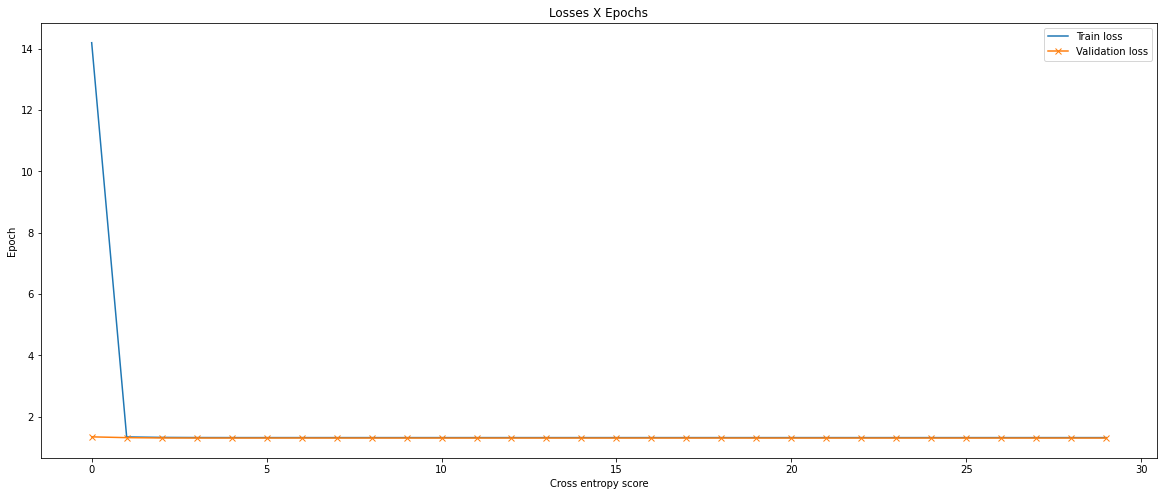

In [ ]:
plot_losses(history1)

In [ ]:
evaluate(model1, train_dl)

{'epoch_acc': 0.3789389431476593, 'epoch_loss': 1.3162277936935425}